In [6]:
import numpy as np
from scipy.ndimage import distance_transform_edt, distance_transform_cdt, distance_transform_bf
import PIL.Image as Image
from PIL import ImageFilter, ImageStat

MAGIC = 255

def _get_distance_map(img_array: np.array, thresh: int = 10, pow: float = 0.5) -> np.array:
    # Relative distance to nearest black pixel
    black_mask = np.all(img_array[:, :, :3] <= [thresh, thresh, thresh], axis=-1) & (img_array[:, :, 3] >= MAGIC - thresh)
    dis_map = distance_transform_edt(~black_mask)
    return np.pow(dis_map / np.max(dis_map), pow)

def gradient_map(img: Image, thresh: int = 10, pow: float = 0.5) -> Image:
    # Gradient map for 3D shading assistance
    if img.mode != 'RGBA':
        img = img.convert('RGBA')
    img_array = np.array(img)
    output_image = Image.new('RGBA', img_array.shape[0:2])
    dis_map = _get_distance_map(img_array, thresh=thresh, pow=pow)
    pixels = output_image.load()

    for i in range(output_image.size[0]):
        for j in range(output_image.size[1]):
            pixels[i,j] = (int(MAGIC*dis_map[i,j]),
                            int(MAGIC*dis_map[i,j]),
                            int(MAGIC*dis_map[i,j]),
                            int(img_array[i,j,3]*dis_map[i,j]))

    return output_image

def outline_simplify(img: Image) -> Image:
    # Colours the inside of the image white, while outlining the edges in black
    if img.mode != 'RGBA':
        img = img.convert('RGBA')
    imgf = img.filter(ImageFilter.FIND_EDGES)
    pixelsf = imgf.load()
    pixels = img.load()
    for i in range(imgf.size[0]):
        for j in range(imgf.size[1]):
            edge_alph = pixelsf[i,j][3]
            tup = (MAGIC - edge_alph,
                MAGIC - edge_alph,
                MAGIC - edge_alph,
                MAGIC*pixels[i,j][3])
            pixelsf[i,j] = tup
    return imgf

def displacement_map(img: Image, map: Image, xdis: int = 10, ydis: int = 10):
    assert img.size == map.size
    res = Image.new('RGBA', img.size)
    res_pixels = res.load()
    pixels = img.load()
    map_pixels = map.load()
    for i in range(res.size[0]):
        for j in range(res.size[1]):
            mp = map_pixels[i,j]
            darkness = 1- (mp[0]+mp[1]+mp[2])*mp[3] / (3*MAGIC*MAGIC)
            x, y = (i - int(darkness*xdis)) % res.size[0], (j - int(darkness*ydis)) % res.size[1]
            res_pixels[i, j] = pixels[x, y]
    return res




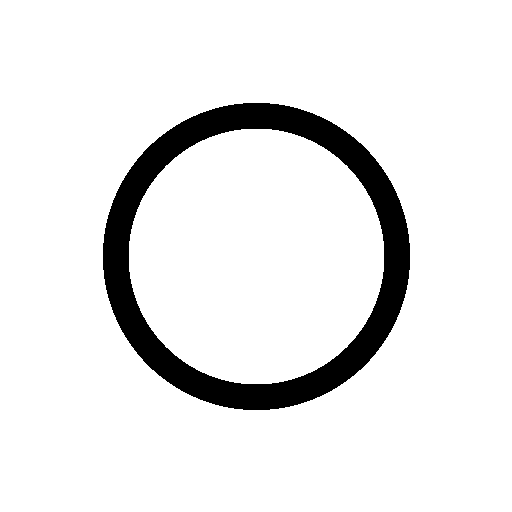

In [2]:
sz = 512
sample_image = Image.new('RGBA', (sz, sz))
pixels = sample_image.load()
for i in range(sample_image.size[0]):
    for j in range(sample_image.size[1]):
        dis = ((sz/2 - i)**2 + (sz/2 - j)**2)**(1/2)
        if dis < 0.25*sz:
            pixels[i,j] = (255, 255, 255, 255)
        elif 0.25*sz <= dis < 0.3*sz:
            pixels[i,j] = (0, 0, 0, 255)
        else:
            pixels[i,j] = (0, 0, 0, 0)
display(sample_image)


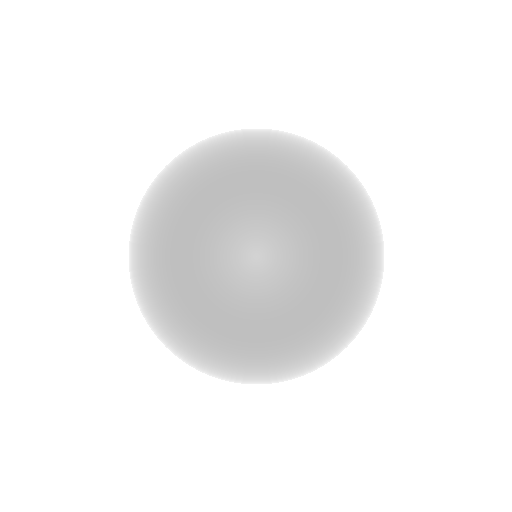

In [3]:
img = sample_image
output_image = gradient_map(img, thresh=3)

display(output_image)

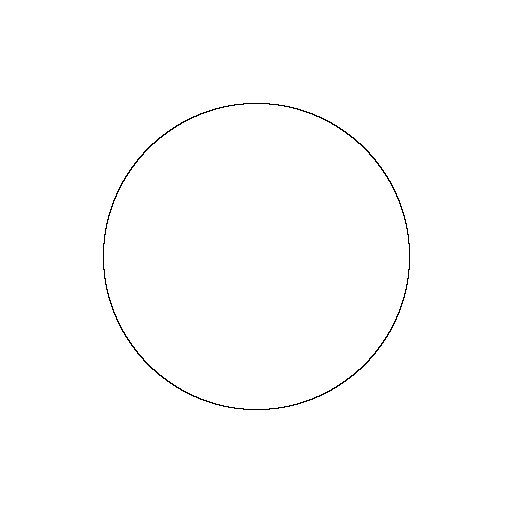

In [4]:
img = sample_image
output_image = outline_simplify(img)
display(output_image)

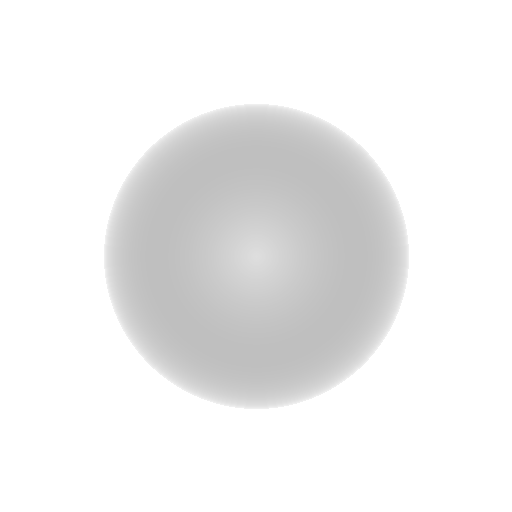

In [5]:
mapped_image = gradient_map(output_image)
display(mapped_image)

In [12]:
im = mapped_image.convert('L')
